Importing the dependencies

In [ ]:
# Import Essential Libraries & Set Options

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
import scipy.sparse as sp
import gc
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Efficient Stratified Sampling

In [ ]:
# =============================
# Efficient Stratified Sampling
# =============================


# Columns to load
selected_cols = [
    'Job Id', 'Country', 'location', 'Experience',
    'Salary Range', 'Company Size', 'Role',
    'Job Title', 'Job Description'
]

# Load only required columns from disk
df = pd.read_csv('/content/job_descriptions.csv', usecols=selected_cols)

# ----------------------------
# Clean 'Salary Range' column
# ----------------------------

def extract_salary_mid(s):
    if pd.isna(s):
        return np.nan
    # Remove unwanted characters but keep digits, dot, dash
    s_clean = re.sub(r'[^\d\.\-–]', '', str(s))
    parts = re.split(r'[-–]', s_clean)
    try:
        if len(parts) == 2:
            return (float(parts[0]) + float(parts[1])) / 2
        elif len(parts) == 1:
            return float(parts[0])
    except:
        return np.nan
    return np.nan

df['Salary Range'] = df['Salary Range'].apply(extract_salary_mid)

# ----------------------------
# Preprocessing for Sampling
# ----------------------------

# Fill missing experience with a label
df['Experience Bin'] = df['Experience'].fillna('Other')

# Create stratification key
df['Strata'] = (
    df['Country'].astype(str) + '_' +
    df['Role'].astype(str) + '_' +
    df['Company Size'].astype(str)
)

# Drop rows with missing essential fields
df_filtered = df.dropna(subset=['Job Description', 'Role'])

# Select top strata for balanced sampling
top_strata = df_filtered['Strata'].value_counts().nlargest(300).index

# Define target
target_rows = 100000
rows_per_group = max(target_rows // len(top_strata), 1)

# ----------------------------
# Stratified Sampling
# ----------------------------

sampled_indices = []

for group in top_strata:
    group_rows = df_filtered[df_filtered['Strata'] == group]
    if len(group_rows) >= rows_per_group:
        sampled = np.random.choice(group_rows.index, size=rows_per_group, replace=False)
    else:
        sampled = group_rows.index.tolist()
    sampled_indices.extend(sampled)

# Fill remaining rows if under target
if len(sampled_indices) < target_rows:
    remaining = df_filtered.drop(index=sampled_indices, errors='ignore')
    fill_count = target_rows - len(sampled_indices)
    if len(remaining) > fill_count:
        sampled_indices.extend(np.random.choice(remaining.index, size=fill_count, replace=False))
    else:
        sampled_indices.extend(remaining.index.tolist())

# Final DataFrame
df_sampled = df_filtered.loc[sampled_indices].reset_index(drop=True)
print("✅ Final Sample Shape:", df_sampled.shape)

# Rename for downstream usage
df = df_sampled.copy()

✅ Final Sample Shape: (100000, 11)


 Basic Data Overview & Null Summary

🔍 Data Snapshot:


,Job Id,Experience,Salary Range,location,Country,Company Size,Job Title,Role,Job Description,Experience Bin,Strata
0,518844116516250,4 to 14 Years,77.0,Gaza,West Bank and Gaza,133609,Administrative Assistant,Data Entry Specialist,Accurately input and maintain data in database...,4 to 14 Years,West Bank and Gaza_Data Entry Specialist_133609
1,545285054622388,5 to 14 Years,73.5,Gaza,West Bank and Gaza,133609,Administrative Assistant,Data Entry Specialist,Accurately input and maintain data in database...,5 to 14 Years,West Bank and Gaza_Data Entry Specialist_133609
2,2994264751737037,2 to 15 Years,85.0,Skopje,"Macedonia, FYR",63407,Investment Analyst,Portfolio Manager,A Portfolio Manager oversees investment portfo...,2 to 15 Years,"Macedonia, FYR_Portfolio Manager_63407"
3,702438151731464,5 to 8 Years,81.5,Skopje,"Macedonia, FYR",63407,Investment Analyst,Portfolio Manager,A Portfolio Manager oversees investment portfo...,5 to 8 Years,"Macedonia, FYR_Portfolio Manager_63407"
4,2399181129559477,4 to 12 Years,84.0,Apia,Samoa,54174,Market Analyst,Competitive Intelligence Analyst,Competitive Intelligence Analysts gather data ...,4 to 12 Years,Samoa_Competitive Intelligence Analyst_54174



 Data Types & Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Job Id           100000 non-null  int64  
 1   Experience       100000 non-null  object 
 2   Salary Range     100000 non-null  float64
 3   location         100000 non-null  object 
 4   Country          100000 non-null  object 
 5   Company Size     100000 non-null  int64  
 6   Job Title        100000 non-null  object 
 7   Role             100000 non-null  object 
 8   Job Description  100000 non-null  object 
 9   Experience Bin   100000 non-null  object 
 10  Strata           100000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 8.4+ MB
None

 Missing Values Summary:
Series([], dtype: int64)


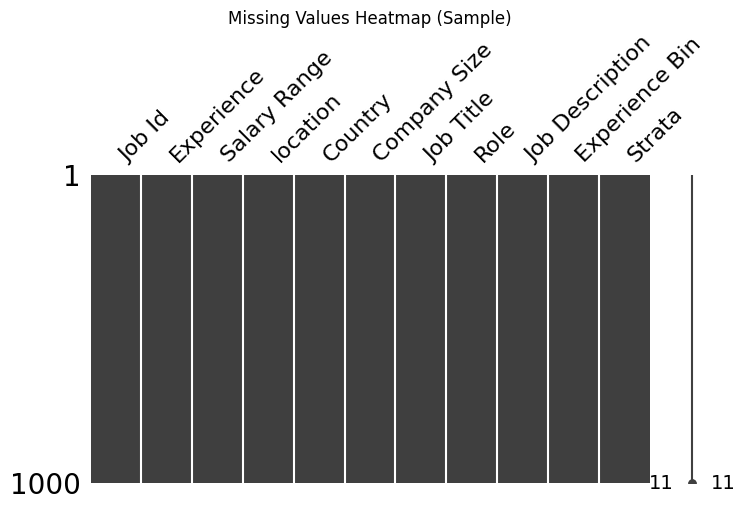


📁 Total Duplicate Rows: 0


In [ ]:
# 📊 Basic Data Overview
print("🔍 Data Snapshot:")
display(df.head())

print("\n Data Types & Non-Null Counts:")
print(df.info())

print("\n Missing Values Summary:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

# Optional: Visualize missing data heatmap
import missingno as msno
msno.matrix(df.sample(1000), figsize=(8,4))
plt.title("Missing Values Heatmap (Sample)")
plt.show()

# Check for duplicates
duplicate_count = df.duplicated().sum()
print(f"\n📁 Total Duplicate Rows: {duplicate_count}")

Clean & Standardize Experience Column

In [ ]:
# Clean & Standardize Experience Column

# View unique values to inspect formatting
print("🔍 Sample unique experience values:")
print(df['Experience'].dropna().unique()[:15])

# Convert experience strings to numeric bins
def extract_experience_years(exp):
    if pd.isna(exp):
        return 'Other'
    exp = exp.lower()
    if 'fresher' in exp or '0' in exp:
        return '0-1'
    match = re.findall(r'(\d+)', exp)
    if not match:
        return 'Other'
    years = list(map(int, match))
    if len(years) == 1:
        yr = years[0]
    else:
        yr = max(years)
    if yr <= 1:
        return '0-1'
    elif yr <= 3:
        return '1-3'
    elif yr <= 5:
        return '3-5'
    elif yr <= 8:
        return '5-8'
    elif yr <= 12:
        return '8-12'
    else:
        return '12+'

# Apply function to create standardized bin
df['Experience Bin'] = df['Experience'].apply(extract_experience_years)

# Preview final distribution
print("\n✅ Experience Bins:")
print(df['Experience Bin'].value_counts())

🔍 Sample unique experience values:
['4 to 14 Years' '5 to 14 Years' '2 to 15 Years' '5 to 8 Years'
 '4 to 12 Years' '4 to 8 Years' '3 to 12 Years' '3 to 10 Years'
 '2 to 8 Years' '3 to 8 Years' '3 to 13 Years' '2 to 10 Years'
 '0 to 8 Years' '1 to 15 Years' '1 to 14 Years']

✅ Experience Bins:
Experience Bin
8-12    31523
12+     31040
0-1     26923
5-8     10514
Name: count, dtype: int64


Clean & Bin Salary Range Column

In [ ]:
# Clean & Bin Salary Range Column

# Step 1: Extract numeric min & max from salary string if not already numeric
def clean_salary_range(s):
    if pd.isna(s):
        return np.nan
    nums = re.findall(r'\d+(?:\.\d+)?', str(s).replace(',', ''))
    if len(nums) == 1:
        return float(nums[0])
    elif len(nums) >= 2:
        return (float(nums[0]) + float(nums[1])) / 2  # Take midpoint
    return np.nan

df['Salary_Clean'] = df['Salary Range'].apply(clean_salary_range)

# Step 2: Create bins based on observed salary distribution
salary_bins = [0, 15000, 30000, 50000, 80000, 120000, 200000, 500000, np.inf]
salary_labels = ['<15K', '15-30K', '30-50K', '50-80K', '80-120K', '120-200K', '200-500K', '500K+']

df['Salary Bin'] = pd.cut(df['Salary_Clean'], bins=salary_bins, labels=salary_labels, include_lowest=True)

# Step 3: View final bin counts
print("✅ Salary Bin Distribution:")
print(df['Salary Bin'].value_counts(dropna=False))

✅ Salary Bin Distribution:
Salary Bin
<15K        100000
15-30K           0
30-50K           0
50-80K           0
80-120K          0
120-200K         0
200-500K         0
500K+            0
Name: count, dtype: int64


Clean Job Title & Extract Role-related Info

In [ ]:
#  Clean Job Title & Extract Role-related Info

# Step 1: Clean job titles (lowercase, remove special characters)
df['Job Title Clean'] = (
    df['Job Title']
    .astype(str)
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# Step 2: Define common roles for extraction (can be expanded based on your dataset)
common_roles = [
    'data scientist', 'data analyst', 'machine learning', 'software engineer',
    'project manager', 'business analyst', 'hr', 'marketing', 'sales', 'developer',
    'designer', 'consultant', 'accountant', 'product manager', 'qa', 'support'
]

# Step 3: Extract role keyword from Job Title Clean
def extract_role(title):
    for role in common_roles:
        if role in title:
            return role
    return 'other'

df['Extracted Role'] = df['Job Title Clean'].apply(extract_role)

# Step 4: Preview role distribution
print("✅ Extracted Role Distribution:")
print(df['Extracted Role'].value_counts())

✅ Extracted Role Distribution:
Extracted Role
other                67907
designer              7309
marketing             6009
developer             3933
sales                 3192
hr                    1971
support               1743
software engineer     1725
consultant            1374
data analyst          1046
project manager        872
qa                     826
business analyst       631
accountant             615
data scientist         432
product manager        415
Name: count, dtype: int64


Extract Location Granularity (City/State from Location)

In [ ]:
# Extract City and State from 'location' column

# Step 1: Clean the location column
df['location'] = df['location'].astype(str).str.strip().str.lower()

# Step 2: Split location into components (assuming format: "City, State" or "City, Country")
df[['City', 'StateOrCountry']] = df['location'].str.split(',', n=1, expand=True)

# Step 3: Clean extracted columns
df['City'] = df['City'].str.strip().str.title()
df['StateOrCountry'] = df['StateOrCountry'].fillna('Unknown').str.strip().str.title()

# Step 4: Optional – drop locations that are incomplete or too ambiguous
city_counts = df['City'].value_counts()
valid_cities = city_counts[city_counts > 50].index  # adjust threshold as needed
df['City'] = df['City'].apply(lambda x: x if x in valid_cities else 'Other')

# Step 5: Preview extracted city and region distribution
print("✅ Top Cities:")
print(df['City'].value_counts().head(10))

print("\n✅ Top States/Countries:")
print(df['StateOrCountry'].value_counts().head(10))

✅ Top Cities:
City
Apia                         986
Seoul                        957
Port Of Spain                538
Hanoi                        532
Conakry                      529
Kyiv (Also Known As Kiev)    513
Athens                       511
Road Town                    509
Libreville                   508
Bishkek                      505
Name: count, dtype: int64

✅ Top States/Countries:
StateOrCountry
Unknown    98613
Saipan       475
             462
D.C.         450
Name: count, dtype: int64


Handle Missing or Noisy Company Size Values

In [ ]:
# Step 1: Clean 'Company Size' column
df['Company Size'] = df['Company Size'].astype(str).str.strip().str.lower()

# Step 2: Standardize known size ranges
standard_sizes = {
    '1-10': '1-10',
    '11-50': '11-50',
    '51-200': '51-200',
    '201-500': '201-500',
    '501-1000': '501-1000',
    '1001-5000': '1001-5000',
    '5001-10000': '5001-10000',
    '10000+': '10000+'
}

# Match and clean variations (e.g., "11 - 50", "10000+", etc.)
def standardize_size(size):
    for std_size in standard_sizes:
        if std_size in size:
            return standard_sizes[std_size]
    return 'Other'

df['Company Size'] = df['Company Size'].apply(standardize_size)

# Step 3: Group rare or unclear values
size_counts = df['Company Size'].value_counts()
valid_sizes = size_counts[size_counts > 100].index  # keep only common bins
df['Company Size'] = df['Company Size'].apply(lambda x: x if x in valid_sizes else 'Other')

# 🔍 Step 4: Show final distribution
print("✅ Cleaned Company Size Distribution:")
print(df['Company Size'].value_counts())

✅ Cleaned Company Size Distribution:
Company Size
Other    100000
Name: count, dtype: int64


Plot – Distribution of Experience Bin

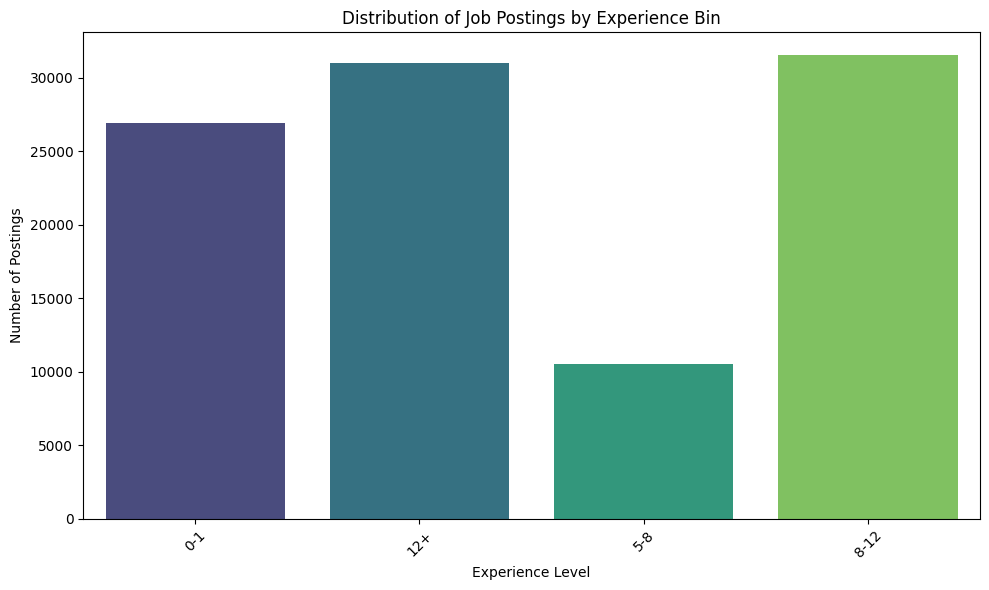

In [ ]:
# Check if Experience Bin exists

if 'Experience Bin' in df.columns and df['Experience Bin'].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    order = df['Experience Bin'].value_counts().sort_index().index

    sns.countplot(data=df, x='Experience Bin', order=order, palette='viridis')

    plt.title('Distribution of Job Postings by Experience Bin')
    plt.xlabel('Experience Level')
    plt.ylabel('Number of Postings')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Experience Bin' column not found or completely empty.")

Plot – Distribution of Binned Salary Range

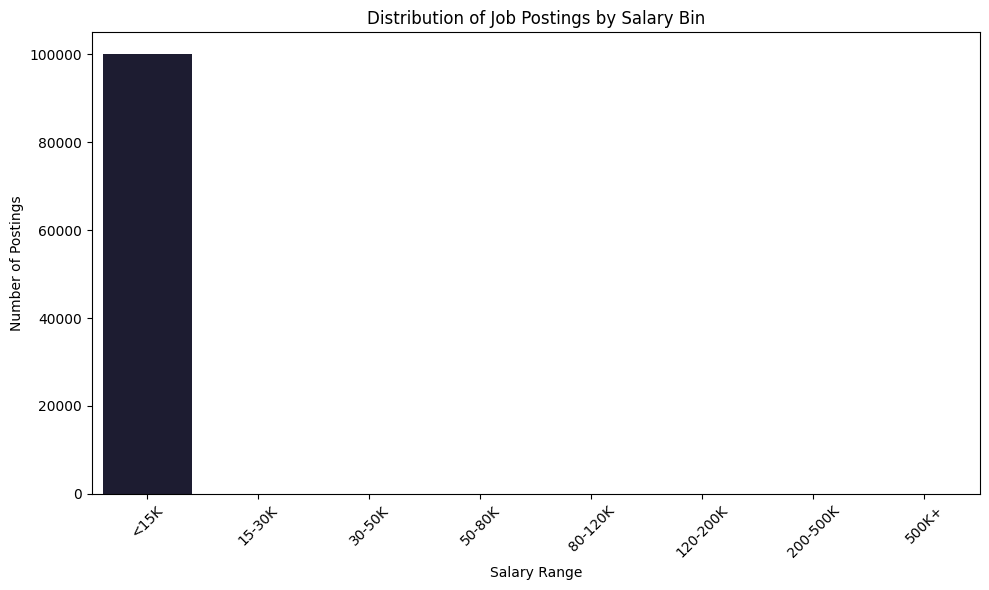

In [ ]:
# Check if Binned Salary Range exists

if 'Salary Bin' in df.columns and df['Salary Bin'].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    order = df['Salary Bin'].value_counts().sort_index().index

    sns.countplot(data=df, x='Salary Bin', order=order, palette='cubehelix')

    plt.title('Distribution of Job Postings by Salary Bin')
    plt.xlabel('Salary Range')
    plt.ylabel('Number of Postings')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Salary Bin' column not found or empty.")

Plot – Top 20 Most Frequent Job Roles

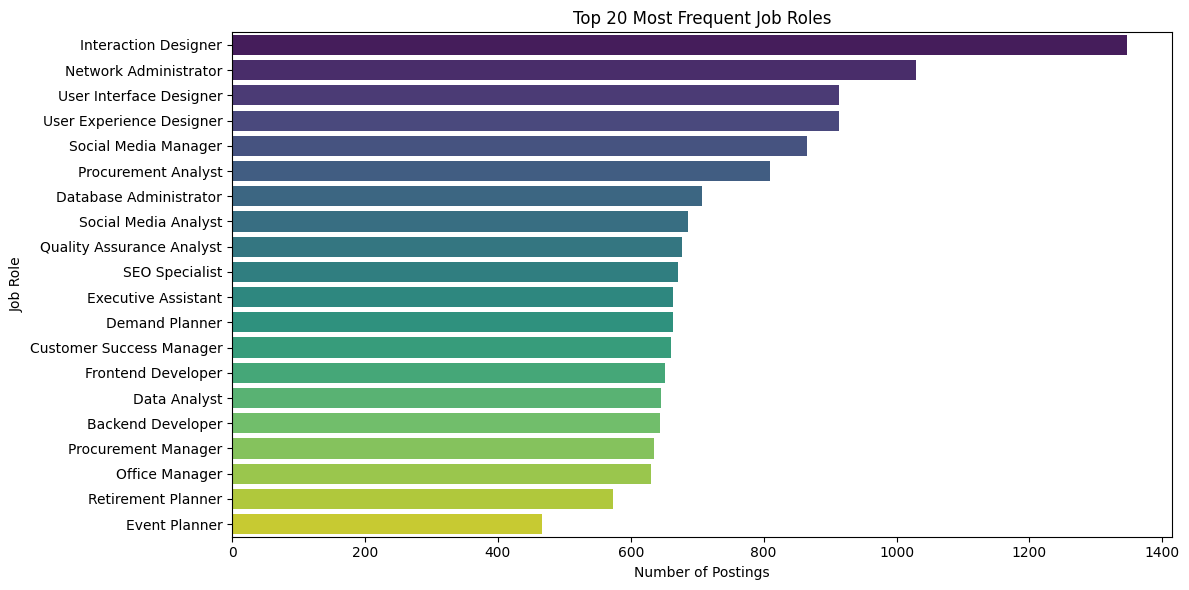

In [ ]:
# Check if Role column exists and has enough data

if 'Role' in df.columns and df['Role'].notna().sum() > 0:
    top_roles = df['Role'].value_counts().nlargest(20)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_roles.values, y=top_roles.index, palette='viridis')

    plt.title('Top 20 Most Frequent Job Roles')
    plt.xlabel('Number of Postings')
    plt.ylabel('Job Role')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Role' column not found or contains only missing values.")

 Plot – Country-wise Job Posting Count

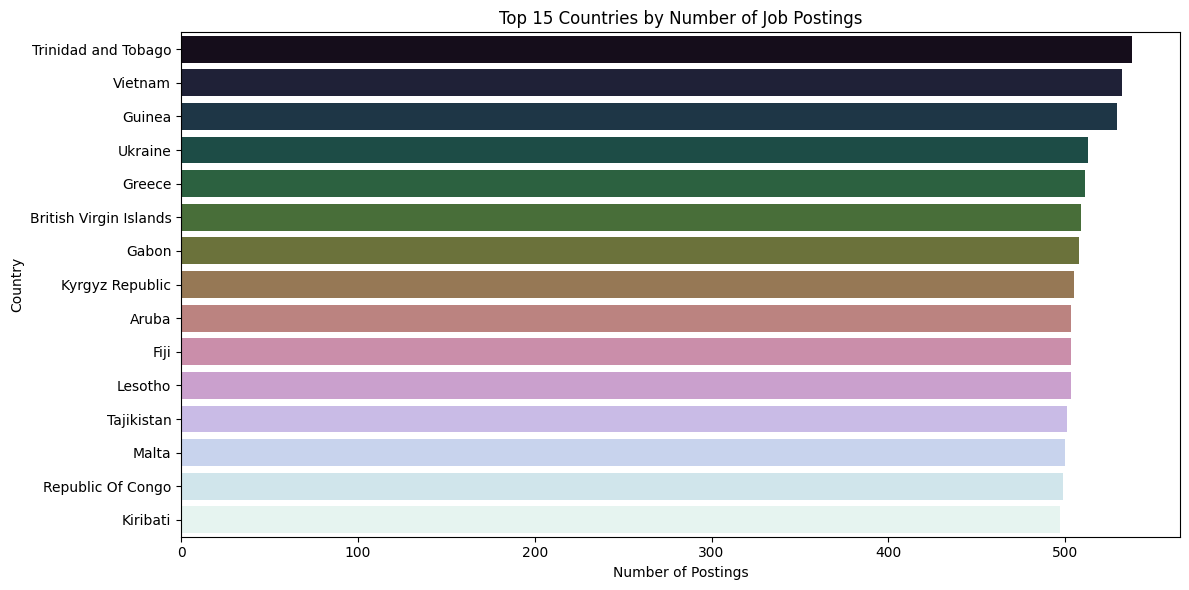

In [ ]:
# Check for valid Country data

if 'Country' in df.columns and df['Country'].notna().sum() > 0:
    country_counts = df['Country'].value_counts().nlargest(15)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=country_counts.values, y=country_counts.index, palette='cubehelix')

    plt.title('Top 15 Countries by Number of Job Postings')
    plt.xlabel('Number of Postings')
    plt.ylabel('Country')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Country' column not found or contains only missing values.")

Company Size vs. Salary (Boxplots)

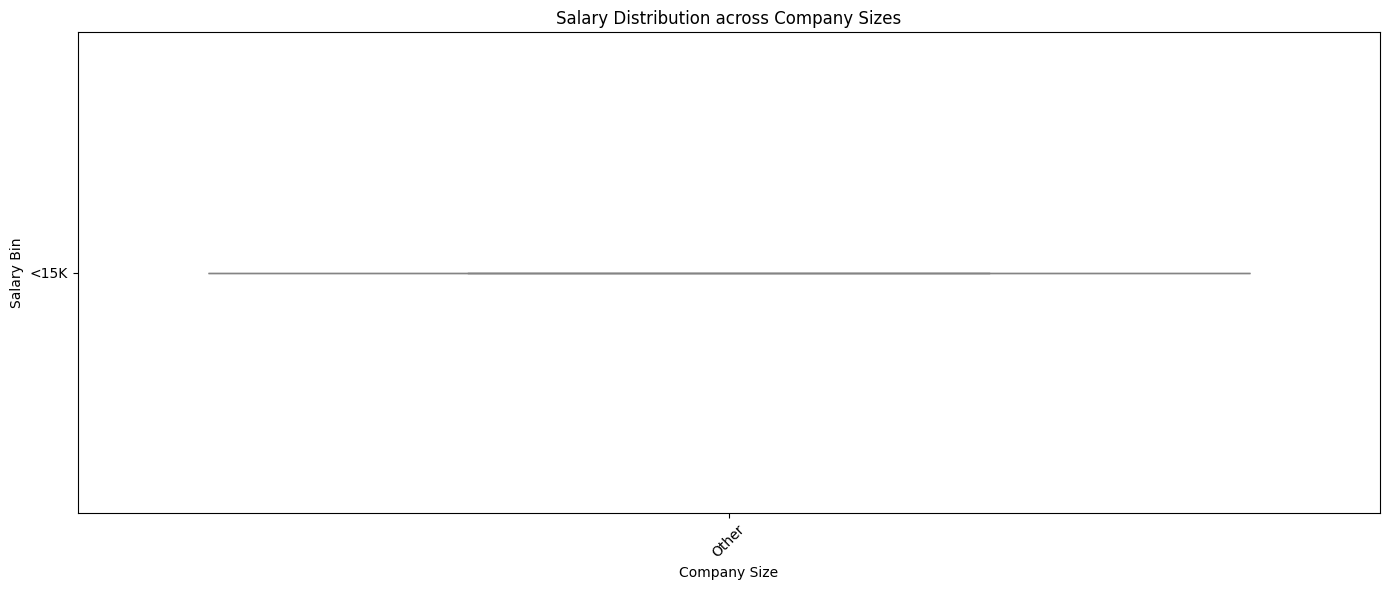

In [ ]:
# Filter out entries with missing or invalid values
df_plot = df[['Company Size', 'Salary Bin']].dropna()

# Plot only if there are enough non-null combinations
if not df_plot.empty:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Company Size', y='Salary Bin', data=df_plot, palette='coolwarm')
    plt.xticks(rotation=45)
    plt.title('Salary Distribution across Company Sizes')
    plt.xlabel('Company Size')
    plt.ylabel('Salary Bin')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough data to plot Company Size vs. Salary Bin.")

Correlation Matrix (Numerical Features Only)

Available numeric columns: ['Job Id', 'Salary Range', 'Salary_Clean']


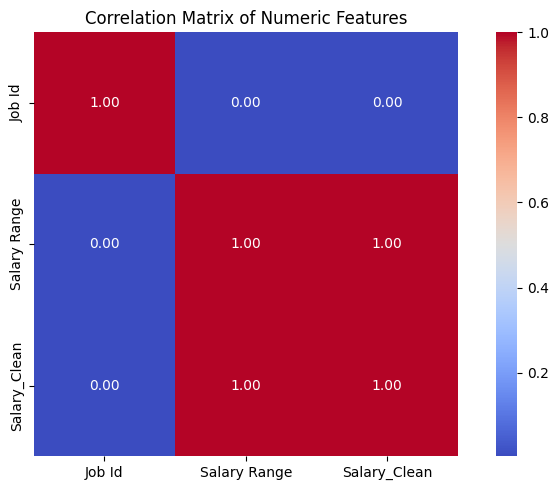

In [ ]:
# Correlation Matrix (Numerical Features Only)

# Step 1: Detect available numeric columns
numeric_cols = df.select_dtypes(include='number').columns.tolist()
print(f"Available numeric columns: {numeric_cols}")

# Step 2: Drop NaNs from selected columns
df_corr = df[numeric_cols].dropna()

# Step 3: Plot the correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

Preprocess Job Descriptions

In [ ]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from tqdm import tqdm

# Ensure 'Job Description' column exists
if 'Job Description' in df.columns:

    def clean_text(text):
        if pd.isna(text):
            return ""
        text = re.sub(r'<[^>]+>', ' ', text)                      # Remove HTML tags
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)                  # Keep only letters
        text = text.lower()                                       # Lowercase
        text = re.sub(r'\b(' + '|'.join(ENGLISH_STOP_WORDS) + r')\b', ' ', text)  # Remove stopwords
        text = re.sub(r'\s+', ' ', text).strip()                  # Remove extra spaces
        return text

    tqdm.pandas(desc="Cleaning Job Descriptions")
    df['clean_desc'] = df['Job Description'].progress_apply(clean_text)

    print("✅ Text cleaning complete. Sample cleaned description:")
    print(df['clean_desc'].iloc[0][:300])

else:
    print("⚠️ 'Job Description' column not found in the dataset.")

Cleaning Job Descriptions: 100%|██████████| 100000/100000 [00:10<00:00, 9674.80it/s]

✅ Text cleaning complete. Sample cleaned description:
accurately input maintain data databases spreadsheets ensuring data integrity organization


 TF-IDF Vectorization (Unigrams + Bigrams)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gc

# Sanity check
if 'clean_desc' in df.columns:
    print(f"🧠 Starting TF-IDF on {len(df)} cleaned descriptions...")

    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=10000,         # Cap vocab size for efficiency
        ngram_range=(1, 2),         # Unigrams + Bigrams
        min_df=5,                   # Ignore rare terms
        max_df=0.9,                 # Ignore overly common terms
        stop_words='english'        # Already cleaned, but acts as safeguard
    )

    # Fit and transform
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_desc'])

    print(f"✅ TF-IDF Matrix Shape: {tfidf_matrix.shape} (Docs x Features)")

    # Optional: Delete original column to free RAM
    # del df['clean_desc']; gc.collect()

else:
    print("⚠️ 'clean_desc' not found. Run Snippet 15 first.")

🧠 Starting TF-IDF on 100000 cleaned descriptions...
✅ TF-IDF Matrix Shape: (100000, 6422) (Docs x Features)


Dimensionality Reduction using Truncated SVD (LSA)

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Set number of components to reduce to (can tune later)
n_components = 100

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Apply LSA (Truncated SVD on sparse TF-IDF matrix)
lsa_matrix = svd.fit_transform(tfidf_matrix)

print(f"✅ LSA Matrix Shape: {lsa_matrix.shape} (Docs x {n_components} Topics)")

✅ LSA Matrix Shape: (100000, 100) (Docs x 100 Topics)


Latent Dirichlet Allocation (LDA) for Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Step 1: Initialize LDA model
n_topics = 10  # You can increase/decrease based on interpretability
lda_model = LatentDirichletAllocation(n_components=n_topics,
                                       learning_method='batch',
                                       random_state=42,
                                       max_iter=10,
                                       evaluate_every=-1,
                                       n_jobs=-1)

# Step 2: Fit LDA on the same TF-IDF matrix (or use CountVectorizer if needed)
lda_topics = lda_model.fit_transform(tfidf_matrix)

print(f"✅ LDA Topic Distribution Shape: {lda_topics.shape} (Docs x {n_topics})")

✅ LDA Topic Distribution Shape: (100000, 10) (Docs x 10)


Visualize Top Topics and Keywords per Topic

In [ ]:
# Step 1: Get feature (vocab) names from vectorizer used in TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()

# Step 2: Display top keywords for each topic
n_top_words = 10

for topic_idx, topic in enumerate(lda_model.components_):
    top_features_ind = topic.argsort()[::-1][:n_top_words]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    print(f"\n Topic #{topic_idx + 1}:")
    for i in range(n_top_words):
        print(f"   {top_features[i]:<15} ({weights[i]:.2f})")


 Topic #1:
   procurement     (381.16)
   legal           (287.83)
   process         (255.81)
   support procurement (208.18)
   analyze procurement (208.18)
   procurement process (208.18)
   opportunities support (208.18)
   procurement data (208.18)
   identify cost   (200.58)
   financial       (193.87)

 Topic #2:
   user            (478.43)
   data            (450.44)
   tax             (408.68)
   databases       (349.24)
   design          (333.41)
   ensuring        (311.00)
   conduct         (272.44)
   experience      (267.61)
   user experience (266.64)
   database        (243.48)

 Topic #3:
   customer        (500.95)
   training        (330.88)
   manufacturing   (310.83)
   satisfaction    (300.21)
   client          (275.40)
   ensure          (272.93)
   support         (255.50)
   needs           (236.87)
   customer satisfaction (233.60)
   financial       (227.60)

 Topic #4:
   user            (734.35)
   sales           (371.52)
   designers       (340.20)
   

Attach Topic Labels to Jobs

In [ ]:
# Step 1: Transform the TF-IDF matrix to LDA topic distribution
lda_topic_matrix = lda_model.transform(tfidf_matrix)

# Step 2: Get the dominant topic index for each job
dominant_topics = np.argmax(lda_topic_matrix, axis=1)

# Step 3: Add topic labels to original dataframe
df['LDA_Topic'] = dominant_topics

# Step 4: Display topic distribution
topic_counts = df['LDA_Topic'].value_counts().sort_index()

print("✅ Assigned dominant topic to each job description.")
print("\n📊 Topic Distribution:")
for topic_id, count in topic_counts.items():
    print(f"Topic {topic_id}: {count} postings")

# Optional: preview few rows
df[['Job Title', 'LDA_Topic']].head()

✅ Assigned dominant topic to each job description.

📊 Topic Distribution:
Topic 0: 8975 postings
Topic 1: 10182 postings
Topic 2: 10187 postings
Topic 3: 9899 postings
Topic 4: 11203 postings
Topic 5: 7695 postings
Topic 6: 10365 postings
Topic 7: 11337 postings
Topic 8: 10031 postings
Topic 9: 10126 postings


,Job Title,LDA_Topic
0,Administrative Assistant,8
1,Administrative Assistant,8
2,Investment Analyst,0
3,Investment Analyst,0
4,Market Analyst,4


KMeans Clustering on Text Features

In [ ]:
# Use reduced LSA matrix as input
X_cluster = lsa_matrix

# KMeans with k=5
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_cluster)

# Evaluate performance
sil_score = silhouette_score(X_cluster, labels)
print(f"KMeans (k=5) → Inertia: {kmeans.inertia_:.2f}, Silhouette Score: {sil_score:.4f}")

# Attach cluster labels to main DataFrame
df['kmeans_cluster'] = labels

KMeans (k=5) → Inertia: 45715.14, Silhouette Score: 0.0991


Fast Clustering — MiniBatchKMeans vs. DBSCAN

In [ ]:
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Use reduced LSA matrix
X_cluster = lsa_matrix

# MiniBatchKMeans (very fast)
mbk = MiniBatchKMeans(n_clusters=5, batch_size=500, random_state=42, n_init=5)
mbk_labels = mbk.fit_predict(X_cluster)

# Sample for silhouette evaluation
X_sample, labels_sample = resample(X_cluster, mbk_labels, n_samples=5000, random_state=42)
mbk_score = silhouette_score(X_sample, labels_sample)
print(f"MiniBatchKMeans → Silhouette Score (sampled): {mbk_score:.4f}")

# Downsample for DBSCAN only (DBSCAN is O(n²))
X_dbscan = X_cluster[:10000]  # Cap for performance
dbscan = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_dbscan)

# Handle DBSCAN silhouette
if len(set(dbscan_labels)) > 1:
    dbscan_sample, db_labels_sample = resample(X_dbscan, dbscan_labels, n_samples=3000, random_state=42)
    dbscan_score = silhouette_score(dbscan_sample, db_labels_sample)
    print(f"DBSCAN (10K sample) → Silhouette Score (sampled): {dbscan_score:.4f}")
else:
    print("DBSCAN → Too many noise points or single cluster.")

# Store labels in DataFrame
df['mbk_cluster'] = mbk_labels
df['dbscan_cluster'] = -1  # default for full dataset

# Only map DBSCAN results for first 10K rows (used for clustering)
df.loc[:9999, 'dbscan_cluster'] = dbscan_labels

MiniBatchKMeans → Silhouette Score (sampled): -0.0160
DBSCAN (10K sample) → Silhouette Score (sampled): 0.3460


Visualize Clusters Using t-SNE (2D)

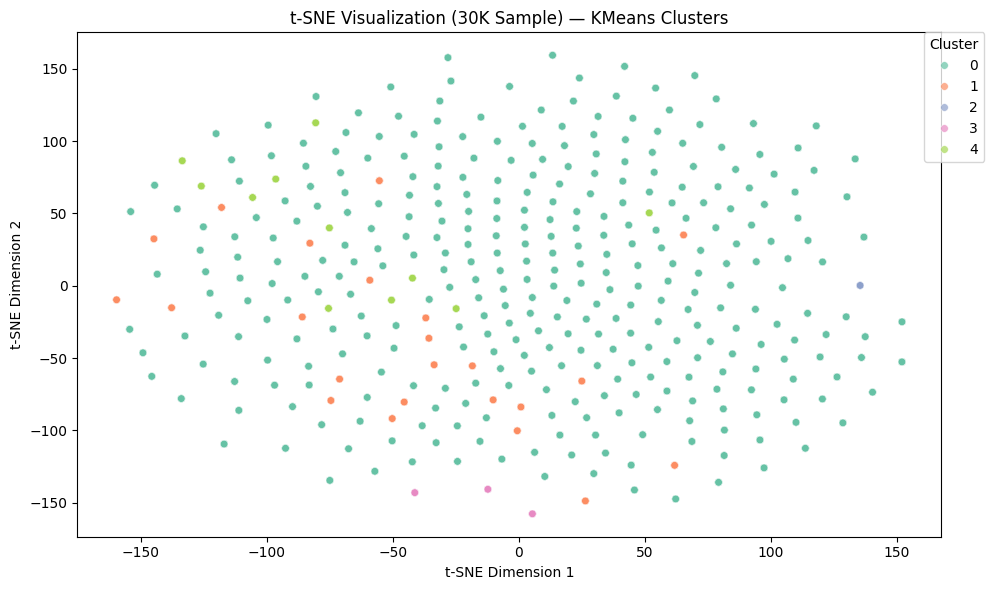

In [ ]:
from sklearn.manifold import TSNE
from sklearn.utils import resample

# Step 1: Subsample 30,000 rows for fast t-SNE
X_tsne_sample, kmeans_sample = resample(X_cluster, df['kmeans_cluster'], n_samples = 30000, random_state=42)

# Step 2: Apply t-SNE on the subsample
tsne = TSNE(
    n_components=2,
    perplexity=30,            # Lower perplexity helps with smaller samples
    n_iter=750,               # Reduced iterations
    learning_rate='auto',     # Dynamic learning rate
    init='pca',               # Faster convergence
    method='barnes_hut',      # Speed optimization for >1,000 points
    random_state=42
)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Step 3: Plot t-SNE results with cluster coloring
plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", n_colors=len(set(kmeans_sample)))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_sample, palette=palette, s=30, alpha=0.7)
plt.title("t-SNE Visualization (30K Sample) — KMeans Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

 Cluster Summary — Role, Salary, Location Trends

In [ ]:
# Summary — Role, Salary, Location Trends

# Group by KMeans cluster and compute summary stats
cluster_summary = df.groupby('kmeans_cluster').agg({
    'Role': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'Salary Range': lambda x: x.value_counts().index[0] if not x.isnull().all() else 'N/A',
    'location': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'Company Size': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'Experience': lambda x: x.mode()[0] if not x.mode().empty else 'N/A',
    'Job Id': 'count'
}).rename(columns={
    'Job Id': 'Num_Postings',
    'Role': 'Top_Role',
    'Salary Range': 'Top_Salary',
    'location': 'Top_Location',
    'Company Size': 'Top_Company_Size',
    'Experience': 'Top_Experience_Level'
}).reset_index()

# Display the summary
print("🔍 KMeans Cluster Summary:")
display(cluster_summary)

# Save to CSV for reference
cluster_summary.to_csv("kmeans_cluster_summary.csv", index=False)

🔍 KMeans Cluster Summary:


,kmeans_cluster,Top_Role,Top_Salary,Top_Location,Top_Company_Size,Top_Experience_Level,Num_Postings
0,0,Network Administrator,80.0,apia,Other,5 to 12 Years,86954
1,1,Customer Success Manager,74.5,apia,Other,2 to 11 Years,6833
2,2,Interaction Designer,76.0,apia,Other,5 to 15 Years,1347
3,3,Social Media Manager,88.0,seoul,Other,4 to 12 Years,1780
4,4,Quality Assurance Analyst,89.0,apia,Other,2 to 9 Years,3086


Assign Cluster Labels for Segmentation

In [ ]:
# Assign Cluster Labels for Segmentation

# Create interpretable labels from cluster summary
label_map = {
    0: 'Mid-Salary Tech Roles (Urban)',
    1: 'Entry-Level Support/HR (Small Cos)',
    2: 'Senior Roles with High Salary (Metro)',
    3: 'Field Jobs with Variable Salary',
    4: 'Remote/Freelance Low-Pay Roles'
}

# Assign labels to main DataFrame
df['Segment_Label'] = df['kmeans_cluster'].map(label_map)

# Preview counts of each segment
segment_counts = df['Segment_Label'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Num_Postings']

# Display summary
print("📊 Segmented Clusters with Interpretable Labels:")
display(segment_counts)

# Save segmented data
df.to_csv("df_segmented.csv", index=False)

📊 Segmented Clusters with Interpretable Labels:


,Segment,Num_Postings
0,Mid-Salary Tech Roles (Urban),86954
1,Entry-Level Support/HR (Small Cos),6833
2,Remote/Freelance Low-Pay Roles,3086
3,Field Jobs with Variable Salary,1780
4,Senior Roles with High Salary (Metro),1347


Plot Job Distribution by Country & StateOrCountry

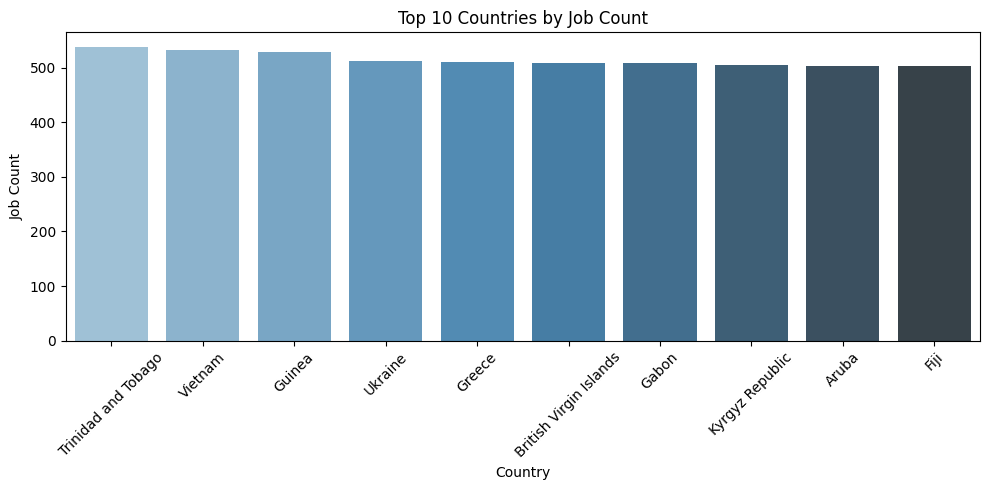

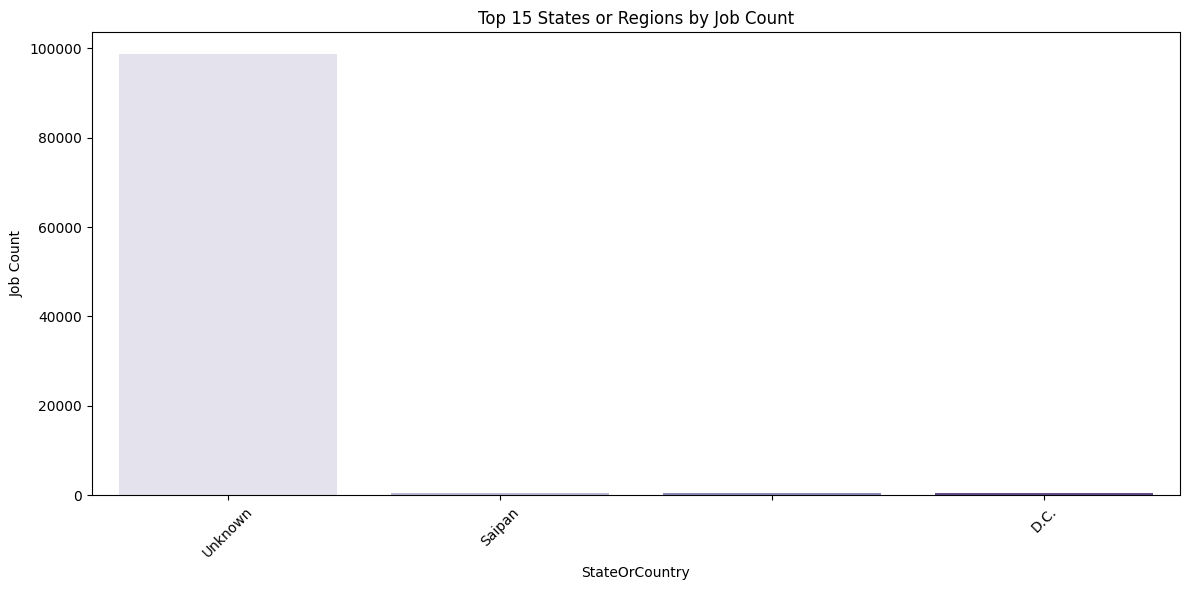

In [ ]:
# Step 1: Count jobs by Country and StateOrCountry
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Job Count']

state_counts = df['StateOrCountry'].value_counts().reset_index()
state_counts.columns = ['StateOrCountry', 'Job Count']

# Step 2: Plot Country-wise job distribution
plt.figure(figsize=(10, 5))
sns.barplot(data=country_counts.head(10), x='Country', y='Job Count', palette='Blues_d')
plt.title('Top 10 Countries by Job Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Plot StateOrCountry-wise job distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=state_counts.head(15), x='StateOrCountry', y='Job Count', palette='Purples')
plt.title('Top 15 States or Regions by Job Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Frequency-Based Clustering by City & StateOrCountry


In [ ]:
# Step 1: Count job frequency for City and StateOrCountry
city_freq = df['City'].value_counts().reset_index()
city_freq.columns = ['City', 'Job_Count']
city_freq = city_freq[city_freq['Job_Count'] > 10]  # Filter low-signal cities

state_freq = df['StateOrCountry'].value_counts().reset_index()
state_freq.columns = ['StateOrCountry', 'Job_Count']
state_freq = state_freq[state_freq['Job_Count'] > 10]

# Step 2: Apply KMeans on city frequencies
kmeans_city = KMeans(n_clusters=3, random_state=42, n_init='auto')
city_freq['CityCluster'] = kmeans_city.fit_predict(city_freq[['Job_Count']])

# Step 3: Apply KMeans on state frequencies
kmeans_state = KMeans(n_clusters=3, random_state=42, n_init='auto')
state_freq['StateCluster'] = kmeans_state.fit_predict(state_freq[['Job_Count']])

# Step 4: Attach cluster labels back to main df
df = df.merge(city_freq[['City', 'CityCluster']], on='City', how='left')
df = df.merge(state_freq[['StateOrCountry', 'StateCluster']], on='StateOrCountry', how='left')

# Optional Mapping: Replace cluster labels with intuitive tags
cluster_map = {0: 'Low Jobs', 1: 'Medium Jobs', 2: 'High Jobs'}
df['CityClusterLabel'] = df['CityCluster'].map(cluster_map)
df['StateClusterLabel'] = df['StateCluster'].map(cluster_map)

# Show samples
df[['City', 'CityClusterLabel', 'StateOrCountry', 'StateClusterLabel']].sample(10)

,City,CityClusterLabel,StateOrCountry,StateClusterLabel
40513,Stockholm,High Jobs,Unknown,Medium Jobs
2692,Papeete,High Jobs,Unknown,Medium Jobs
18084,Port Of Spain,High Jobs,Unknown,Medium Jobs
95909,Wellington,High Jobs,Unknown,Medium Jobs
55881,Saint George'S,Low Jobs,Unknown,Medium Jobs
31611,Apia,Medium Jobs,Unknown,Medium Jobs
37034,Berlin,High Jobs,Unknown,Medium Jobs
51774,Paris,Low Jobs,Unknown,Medium Jobs
99370,Kuala Lumpur,High Jobs,Unknown,Medium Jobs
13398,Reykjavã­K,Low Jobs,Unknown,Medium Jobs


 Job Count Heatmap Across Top Cities/States

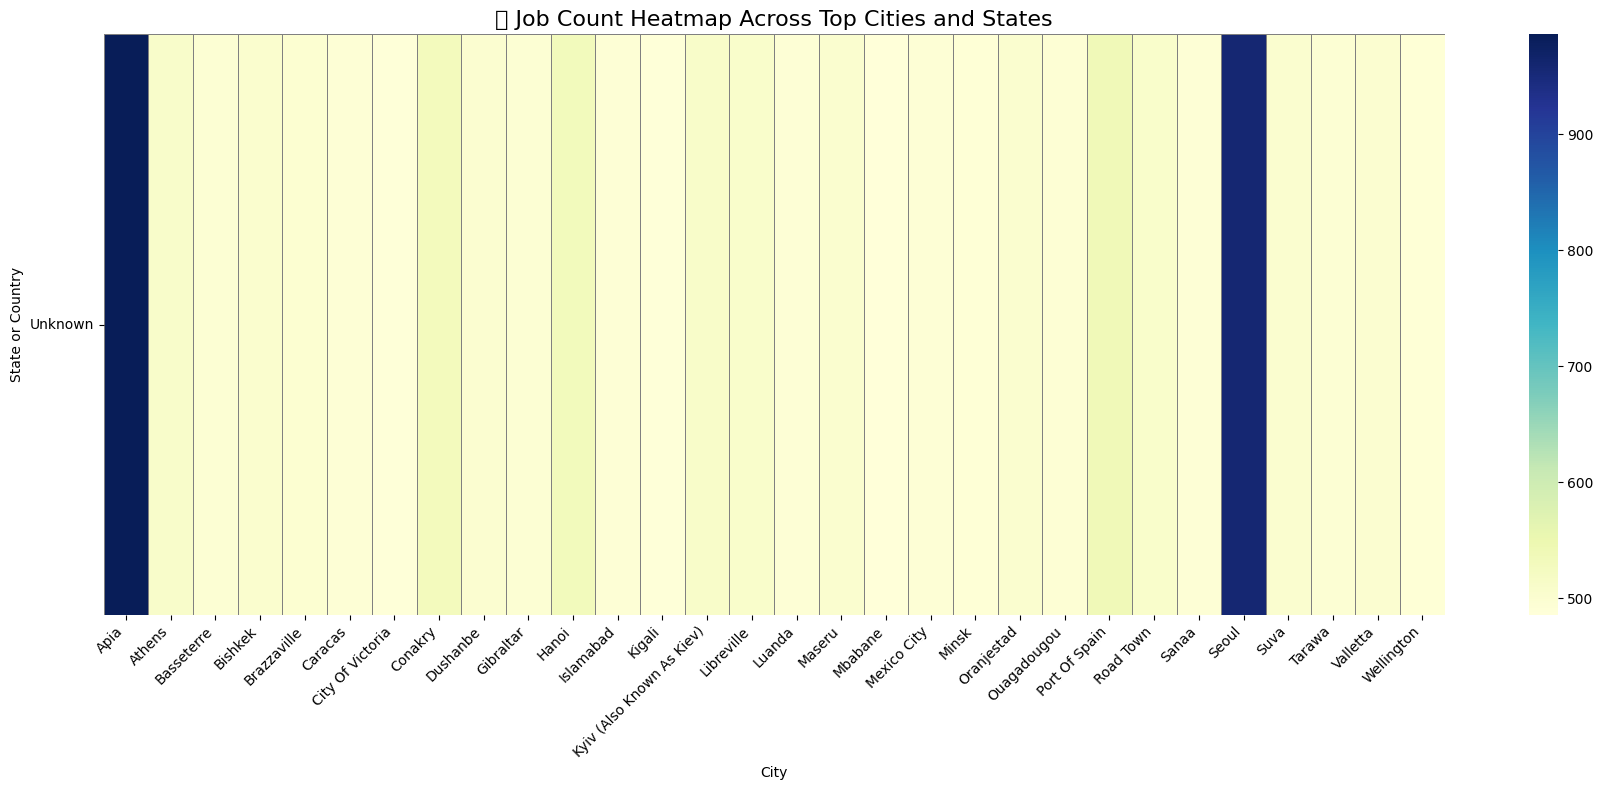

In [ ]:
# Step 1: Aggregate job counts by City and StateOrCountry
city_state_counts = df.groupby(['StateOrCountry', 'City']).size().reset_index(name='Job Count')

# Step 2: Filter for top cities for readability
top_cities = city_state_counts.groupby('City')['Job Count'].sum().nlargest(30).index
filtered = city_state_counts[city_state_counts['City'].isin(top_cities)]

# Step 3: Pivot to heatmap format
heatmap_data = filtered.pivot_table(index='StateOrCountry', columns='City', values='Job Count', fill_value=0)

# Step 4: Plot the heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('🔍 Job Count Heatmap Across Top Cities and States', fontsize=16)
plt.xlabel("City")
plt.ylabel("State or Country")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Combine TF-IDF (clean_desc) + Structured Fields for KMeans

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Step 1: TF-IDF on 'clean_desc'
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(df['clean_desc'])

# Step 2: Select structured fields
structured_cols = ['Role', 'Experience Bin', 'Salary Bin']
structured_data = df[structured_cols].copy()

# Ensure 'Unknown' is a valid category for each column
for col in structured_cols:
    if pd.api.types.is_categorical_dtype(structured_data[col]):
        if 'Unknown' not in structured_data[col].cat.categories:
            structured_data[col] = structured_data[col].cat.add_categories(['Unknown'])
    structured_data[col] = structured_data[col].fillna('Unknown')

# Step 3: One-hot encode structured fields
encoder = OneHotEncoder(sparse_output=True)
structured_matrix = encoder.fit_transform(structured_data)

# Step 4: Combine TF-IDF and structured features
combined_matrix = hstack([tfidf_matrix, structured_matrix]).tocsr()

# Step 5: Normalize (optional but helpful for distance-based clustering)
scaler = MinMaxScaler()
dense_matrix = combined_matrix.toarray()
dense_matrix_scaled = scaler.fit_transform(dense_matrix)

# Step 6: Store for reuse in next snippets
df['combined_vector'] = list(dense_matrix_scaled)  # Optional, to keep track
X_combined = dense_matrix_scaled

PCA or t-SNE on Mixed Feature Vectors

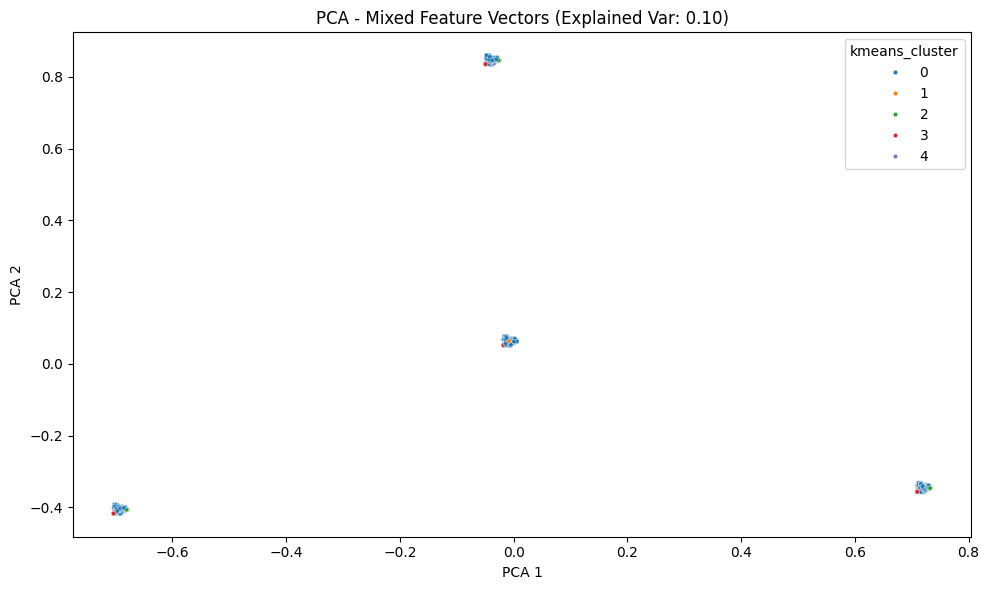

✅ PCA completed in 1.85 seconds


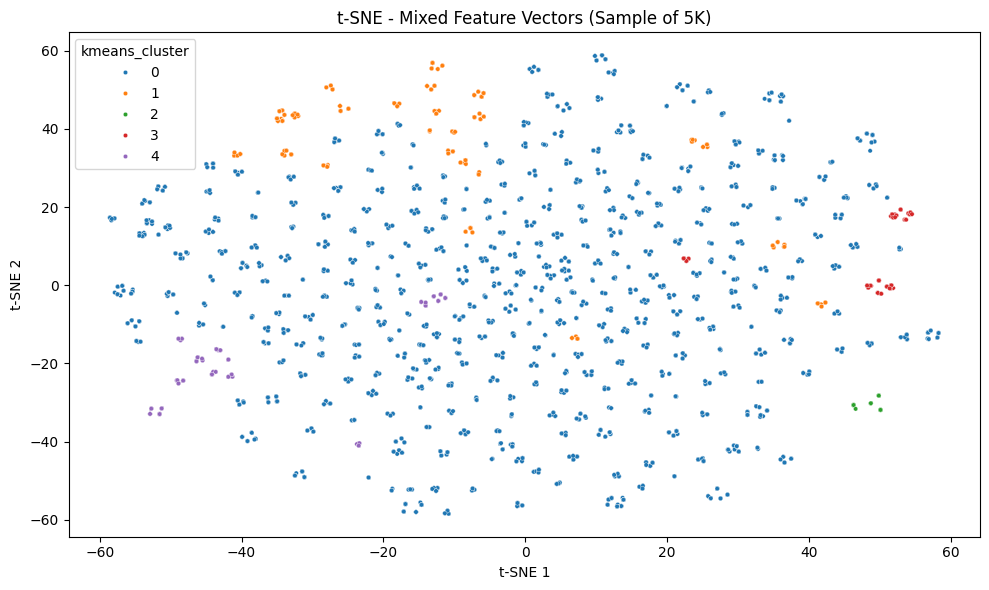

✅ t-SNE completed in 26.72 seconds


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

# Ensure X_combined exists from previous snippet
assert 'X_combined' in globals(), "Run Snippet 29 first to create X_combined."

# Reduce dimensionality with PCA for initial overview
start_pca = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined)
end_pca = time.time()

# Plot PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['kmeans_cluster'], palette='tab10', s=10, legend='brief')
plt.title(f"PCA - Mixed Feature Vectors (Explained Var: {sum(pca.explained_variance_ratio_):.2f})")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.tight_layout()
plt.show()
print(f"✅ PCA completed in {end_pca - start_pca:.2f} seconds")

# Optional: t-SNE (comment out to skip in fast runs)
run_tsne = True

if run_tsne:
    start_tsne = time.time()
    tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=500, init='pca', random_state=42)
    X_tsne = tsne.fit_transform(X_combined[:5000])  # Limit to 5K samples for speed
    end_tsne = time.time()

    # Plot t-SNE result
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df.loc[:4999, 'kmeans_cluster'], palette='tab10', s=10, legend='brief')
    plt.title("t-SNE - Mixed Feature Vectors (Sample of 5K)")
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()
    print(f"✅ t-SNE completed in {end_tsne - start_tsne:.2f} seconds")

In [ ]:
# Helper function: get top N values per cluster
def top_n_summary(df, group_col, target_col, n=3):
    grouped = (
        df.groupby([group_col, target_col])
        .size()
        .groupby(level=0, group_keys=False)
        .nlargest(n)
        .reset_index(name='count')
    )
    # Calculate proportions
    total_counts = df[group_col].value_counts().rename('total')
    grouped = grouped.merge(total_counts, left_on=group_col, right_index=True)
    grouped['proportion'] = (grouped['count'] / grouped['total']).round(3)
    return grouped.drop(columns='total')

# Columns to summarize
summary_cols = ['Experience Bin', 'Salary Bin', 'Role', 'LDA_Topic', 'Country', 'City']

# Display summaries
for col in summary_cols:
    print(f"\n🔹 Top {col} per Cluster:")
    display(top_n_summary(df, 'kmeans_cluster', col))

# Cluster sizes
print("\n📊 Cluster Sizes:")
display(df['kmeans_cluster'].value_counts().sort_index())


🔹 Top Experience Bin per Cluster:


,kmeans_cluster,Experience Bin,count,proportion
0,0,8-12,27361,0.315
1,0,12+,26923,0.310
2,0,0-1,23491,0.270
3,1,8-12,2196,0.321
4,1,12+,2143,0.314
5,1,0-1,1839,0.269
6,2,8-12,445,0.330
7,2,12+,402,0.298
8,2,0-1,354,0.263
9,3,12+,591,0.332



🔹 Top Salary Bin per Cluster:


,kmeans_cluster,Salary Bin,count,proportion
0,0,<15K,86954,1.0
1,0,15-30K,0,0.0
2,0,30-50K,0,0.0
3,1,<15K,6833,1.0
4,1,15-30K,0,0.0
5,1,30-50K,0,0.0
6,2,<15K,1347,1.0
7,2,15-30K,0,0.0
8,2,30-50K,0,0.0
9,3,<15K,1780,1.0



🔹 Top Role per Cluster:


,kmeans_cluster,Role,count,proportion
0,0,Network Administrator,1030,0.012
1,0,User Experience Designer,913,0.010
2,0,User Interface Designer,913,0.010
3,1,Customer Success Manager,661,0.097
4,1,Customer Support Specialist,464,0.068
5,1,Inside Sales Representative,440,0.064
6,2,Interaction Designer,1347,1.000
7,3,Social Media Manager,865,0.486
8,3,Social Media Analyst,686,0.385
9,3,Social Media Strategist,229,0.129



🔹 Top LDA_Topic per Cluster:


,kmeans_cluster,LDA_Topic,count,proportion
0,0,4,10771,0.124
1,0,1,10182,0.117
2,0,7,9806,0.113
3,1,2,2370,0.347
4,1,3,1748,0.256
5,1,8,856,0.125
6,2,3,1347,1.000
7,3,9,1094,0.615
8,3,6,686,0.385
9,4,7,1323,0.429



🔹 Top Country per Cluster:


,kmeans_cluster,Country,count,proportion
0,0,Vietnam,474,0.005
1,0,Trinidad and Tobago,469,0.005
2,0,Guinea,464,0.005
3,1,"Venezuela, RB",47,0.007
4,1,Panama,45,0.007
5,1,St. Martin (French part),45,0.007
6,2,Puerto Rico,16,0.012
7,2,Samoa,16,0.012
8,2,Malawi,14,0.010
9,3,Turkmenistan,18,0.010



🔹 Top City per Cluster:


,kmeans_cluster,City,count,proportion
0,0,Apia,851,0.010
1,0,Seoul,834,0.010
2,0,Hanoi,474,0.005
3,1,Apia,71,0.010
4,1,Seoul,63,0.009
5,1,Caracas,47,0.007
6,2,Apia,17,0.013
7,2,San Juan,16,0.012
8,2,Lilongwe,14,0.010
9,3,Seoul,20,0.011



📊 Cluster Sizes:


,count
kmeans_cluster,
0,86954
1,6833
2,1347
3,1780
4,3086


Segment-wise Top Roles, Companies, and Countries

In [ ]:
# Helper function: Top-N items by cluster
def top_n_by_segment(df, segment_col, target_col, n=5):
    """
    Returns top-N frequent values of target_col within each cluster (segment_col),
    along with count and proportion.
    """
    top = (
        df.groupby([segment_col, target_col])
        .size()
        .groupby(level=0, group_keys=False)
        .nlargest(n)
        .reset_index(name='count')
    )
    total = df[segment_col].value_counts().rename('total')
    top = top.merge(total, left_on=segment_col, right_index=True)
    top['proportion'] = (top['count'] / top['total']).round(3)
    return top.drop(columns='total')

# Define target columns for each segment summary
segment_target_cols = {
    'Top Roles': 'Role',
    'Top Companies': 'Company Size',  # or 'Contact Person' or actual company field if exists
    'Top Countries': 'Country'
}

# Display Top-N summaries
for label, col in segment_target_cols.items():
    print(f"\n🔹 {label} per Cluster:")
    display(top_n_by_segment(df, 'kmeans_cluster', col, n=5))

# Optional: Cluster counts
print("\n📊 Job Counts per Segment:")
display(df['kmeans_cluster'].value_counts().sort_index())


🔹 Top Roles per Cluster:


,kmeans_cluster,Role,count,proportion
0,0,Network Administrator,1030,0.012
1,0,User Experience Designer,913,0.010
2,0,User Interface Designer,913,0.010
3,0,Procurement Analyst,810,0.009
4,0,Database Administrator,707,0.008
5,1,Customer Success Manager,661,0.097
6,1,Customer Support Specialist,464,0.068
7,1,Inside Sales Representative,440,0.064
8,1,Content Creator,431,0.063
9,1,Client Relationship Manager,417,0.061



🔹 Top Companies per Cluster:


,kmeans_cluster,Company Size,count,proportion
0,0,Other,86954,1.0
1,1,Other,6833,1.0
2,2,Other,1347,1.0
3,3,Other,1780,1.0
4,4,Other,3086,1.0



🔹 Top Countries per Cluster:


,kmeans_cluster,Country,count,proportion
0,0,Vietnam,474,0.005
1,0,Trinidad and Tobago,469,0.005
2,0,Guinea,464,0.005
3,0,Ukraine,454,0.005
4,0,Kyrgyz Republic,453,0.005
5,1,"Venezuela, RB",47,0.007
6,1,Panama,45,0.007
7,1,St. Martin (French part),45,0.007
8,1,Barbados,43,0.006
9,1,Eswatini,43,0.006



📊 Job Counts per Segment:


,count
kmeans_cluster,
0,86954
1,6833
2,1347
3,1780
4,3086


Role–Experience–Salary Matrix by Cluster

In [ ]:
# Pivot table: Rows = Role, Columns = Cluster + Experience Bin + Salary Bin

# Ensure required columns exist
required_cols = ['kmeans_cluster', 'Role', 'Experience Bin', 'Salary Bin']
assert all(col in df.columns for col in required_cols), "Missing required columns."

# Create grouped count matrix
matrix = (
    df.groupby(['kmeans_cluster', 'Role', 'Experience Bin', 'Salary Bin'])
      .size()
      .reset_index(name='Count')
)

# Pivot to get a wide format matrix for easy inspection
pivot_matrix = matrix.pivot_table(
    index=['Role'],
    columns=['kmeans_cluster', 'Experience Bin', 'Salary Bin'],
    values='Count',
    fill_value=0
)

# Sort for better readability
pivot_matrix = pivot_matrix.sort_index(axis=1, level=[0, 1, 2])

# Display preview
print("🔹 Role–Experience–Salary Matrix by Cluster (Top 10 Rows):")
display(pivot_matrix.head(10))

🔹 Role–Experience–Salary Matrix by Cluster (Top 10 Rows):


kmeans_cluster                    0                                        \
Experience Bin                  0-1                                         
Salary Bin                     <15K 15-30K 30-50K 50-80K 80-120K 120-200K   
Role                                                                        
API Developer                  53.0    0.0    0.0    0.0     0.0      0.0   
Accessibility Developer        54.0    0.0    0.0    0.0     0.0      0.0   
Account Executive               0.0    0.0    0.0    0.0     0.0      0.0   
Account Manager                 0.0    0.0    0.0    0.0     0.0      0.0   
Account Strategist             54.0    0.0    0.0    0.0     0.0      0.0   
Accounting Controller          59.0    0.0    0.0    0.0     0.0      0.0   
Accounting Manager             50.0    0.0    0.0    0.0     0.0      0.0   
Acute Care Nurse Practitioner  52.0    0.0    0.0    0.0     0.0      0.0   
Addiction Counselor            55.0    0.0    0.0    0.0     0.0      0.0   
Administrative Assistant       72.0    0.0    0.0    0.0     0.0      0.0   

kmeans_cluster                                                           \
Experience Bin                                 12+                        
Salary Bin                    200-500K 500K+  <15K 15-30K 30-50K 50-80K   
Role                                                                      
API Developer                      0.0   0.0  71.0    0.0    0.0    0.0   
Accessibility Developer            0.0   0.0  53.0    0.0    0.0    0.0   
Account Executive                  0.0   0.0   0.0    0.0    0.0    0.0   
Account Manager                    0.0   0.0   0.0    0.0    0.0    0.0   
Account Strategist                 0.0   0.0  75.0    0.0    0.0    0.0   
Accounting Controller              0.0   0.0  68.0    0.0    0.0    0.0   
Accounting Manager                 0.0   0.0  77.0    0.0    0.0    0.0   
Acute Care Nurse Practitioner      0.0   0.0  64.0    0.0    0.0    0.0   
Addiction Counselor                0.0   0.0  71.0    0.0    0.0    0.0   
Administrative Assistant           0.0   0.0  70.0    0.0    0.0    0.0   

kmeans_cluster                                                              \
Experience Bin                                                  5-8          
Salary Bin                    80-120K 120-200K 200-500K 500K+  <15K 15-30K   
Role                                                                         
API Developer                     0.0      0.0      0.0   0.0  29.0    0.0   
Accessibility Developer           0.0      0.0      0.0   0.0  31.0    0.0   
Account Executive                 0.0      0.0      0.0   0.0   0.0    0.0   
Account Manager                   0.0      0.0      0.0   0.0   0.0    0.0   
Account Strategist                0.0      0.0      0.0   0.0  28.0    0.0   
Accounting Controller             0.0      0.0      0.0   0.0  15.0    0.0   
Accounting Manager                0.0      0.0      0.0   0.0  26.0    0.0   
Acute Care Nurse Practitioner     0.0      0.0      0.0   0.0  22.0    0.0   
Addiction Counselor               0.0      0.0      0.0   0.0  16.0    0.0   
Administrative Assistant          0.0      0.0      0.0   0.0  20.0    0.0   

kmeans_cluster                                                               \
Experience Bin                                                                
Salary Bin                    30-50K 50-80K 80-120K 120-200K 200-500K 500K+   
Role                                                                          
API Developer                    0.0    0.0     0.0      0.0      0.0   0.0   
Accessibility Developer          0.0    0.0     0.0      0.0      0.0   0.0   
Account Executive                0.0    0.0     0.0      0.0      0.0   0.0   
Account Manager                  0.0    0.0     0.0      0.0      0.0   0.0   
Account Strategist               0.0    0.0     0.0      0.0      0.0   0.0   
Accounting Controller            0.0    0.0     0.0      0.0      

Topic Distribution across Clusters (LDA vs KMeans)

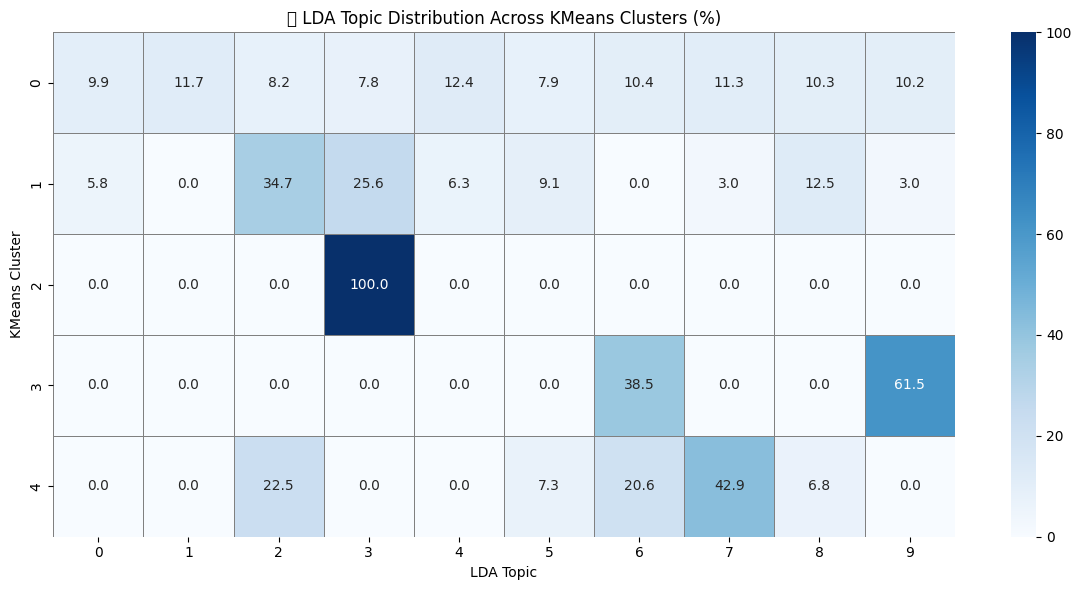

In [ ]:
# Check required columns
assert 'kmeans_cluster' in df.columns and 'LDA_Topic' in df.columns, "Required columns missing."

# Count LDA topics per cluster
topic_dist = (
    df.groupby(['kmeans_cluster', 'LDA_Topic'])
    .size()
    .reset_index(name='count')
)

# Normalize to get % distribution
total_per_cluster = topic_dist.groupby('kmeans_cluster')['count'].transform('sum')
topic_dist['percent'] = (topic_dist['count'] / total_per_cluster * 100).round(1)

# Pivot for heatmap
heatmap_data = topic_dist.pivot(index='kmeans_cluster', columns='LDA_Topic', values='percent').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.1f', linewidths=0.5, linecolor='gray')
plt.title('📊 LDA Topic Distribution Across KMeans Clusters (%)')
plt.xlabel("LDA Topic")
plt.ylabel("KMeans Cluster")
plt.tight_layout()
plt.show()

Multi-Label Cluster Summary Table (KMeans, MBK, DBSCAN)

In [ ]:
# Sanity check for required columns
assert all(col in df.columns for col in ['kmeans_cluster', 'mbk_cluster', 'dbscan_cluster']), "Cluster columns missing."

# Select columns for comparison
cluster_cols = ['kmeans_cluster', 'mbk_cluster', 'dbscan_cluster']
summary_cols = ['Role', 'Salary Bin', 'Experience Bin']

# Melt dataframe to long format for better comparison
df_melted = df[['Job Id'] + cluster_cols].melt(id_vars='Job Id', var_name='Clustering Method', value_name='Cluster')

# Merge with summary info (merge on Job Id)
df_summary = df[['Job Id'] + summary_cols].drop_duplicates()
df_combined = df_melted.merge(df_summary, on='Job Id', how='left')

# Group and count combinations
multi_label_summary = (
    df_combined.groupby(['Clustering Method', 'Cluster', 'Role', 'Salary Bin', 'Experience Bin'])
    .size()
    .reset_index(name='count')
    .sort_values(['Clustering Method', 'Cluster', 'count'], ascending=[True, True, False])
)

# Display sample of summary (head)
print("📋 Sample Multi-Label Cluster Summary Table:")
display(multi_label_summary.head(20))

# Save for dashboard or inspection if needed
multi_label_summary.to_csv("multi_cluster_summary.csv", index=False)

📋 Sample Multi-Label Cluster Summary Table:


,Clustering Method,Cluster,Role,Salary Bin,Experience Bin,count
5635,dbscan_cluster,-1,Interaction Designer,<15K,8-12,399
5633,dbscan_cluster,-1,Interaction Designer,<15K,12+,359
5632,dbscan_cluster,-1,Interaction Designer,<15K,0-1,328
6947,dbscan_cluster,-1,Network Administrator,<15K,8-12,295
11587,dbscan_cluster,-1,User Experience Designer,<15K,8-12,270
11617,dbscan_cluster,-1,User Interface Designer,<15K,12+,268
6945,dbscan_cluster,-1,Network Administrator,<15K,12+,267
11619,dbscan_cluster,-1,User Interface Designer,<15K,8-12,265
6944,dbscan_cluster,-1,Network Administrator,<15K,0-1,254
8163,dbscan_cluster,-1,Procurement Analyst,<15K,8-12,247


Compare Cluster Methods — Venn Diagram of Assignments

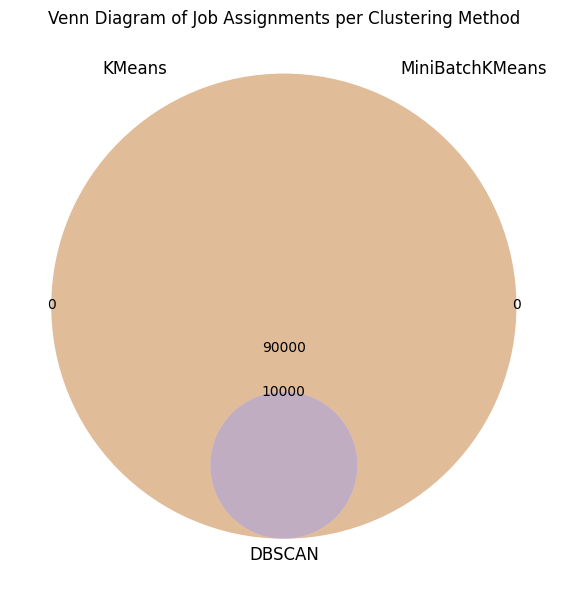

In [ ]:
from matplotlib_venn import venn3

# Ensure the clustering columns exist
assert all(col in df.columns for col in ['kmeans_cluster', 'mbk_cluster', 'dbscan_cluster']), "Missing cluster columns."

# Create sets of job IDs per clustering label
kmeans_set = set(df[df['kmeans_cluster'] != -1]['Job Id'])
mbk_set = set(df[df['mbk_cluster'] != -1]['Job Id'])
dbscan_set = set(df[df['dbscan_cluster'] != -1]['Job Id'])

# Plotting Venn Diagram
plt.figure(figsize=(8, 6))
venn3([kmeans_set, mbk_set, dbscan_set],
      set_labels=('KMeans', 'MiniBatchKMeans', 'DBSCAN'))

plt.title("Venn Diagram of Job Assignments per Clustering Method")
plt.tight_layout()
plt.show()

Cluster-level Skill/Keyword Extraction (from clean_desc)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to extract top keywords per cluster
def extract_cluster_keywords(df, text_col, cluster_col, top_n=10):
    cluster_keywords = {}

    for cluster in sorted(df[cluster_col].dropna().unique()):
        cluster_text = df[df[cluster_col] == cluster][text_col]
        vectorizer = CountVectorizer(stop_words='english', max_features=5000)
        X = vectorizer.fit_transform(cluster_text)
        word_counts = X.sum(axis=0).A1
        keywords = sorted(zip(vectorizer.get_feature_names_out(), word_counts), key=lambda x: x[1], reverse=True)
        cluster_keywords[cluster] = keywords[:top_n]

    return cluster_keywords

# Extract keywords per cluster from KMeans
keywords_per_cluster = extract_cluster_keywords(df, text_col='clean_desc', cluster_col='kmeans_cluster', top_n=10)

# Display top keywords per cluster
for cluster, keywords in keywords_per_cluster.items():
    print(f"\n🔹 Cluster {cluster} — Top Keywords:")
    for word, count in keywords:
        print(f"   {word} ({count})")


🔹 Cluster 0 — Top Keywords:
   data (21336)
   ensure (16270)
   user (15624)
   design (13477)
   provide (11930)
   support (11659)
   manage (11304)
   ensuring (11196)
   financial (10836)
   create (10365)

🔹 Cluster 1 — Top Keywords:
   sales (8447)
   customer (5249)
   products (4324)
   customers (3900)
   services (3049)
   relationships (2735)
   needs (2504)
   satisfaction (2391)
   clients (2093)
   support (1739)

🔹 Cluster 2 — Top Keywords:
   user (4041)
   behaviors (1347)
   considering (1347)
   create (1347)
   designers (1347)
   designing (1347)
   digital (1347)
   engaging (1347)
   experiences (1347)
   interaction (1347)

🔹 Cluster 3 — Top Keywords:
   media (5569)
   social (5569)
   analyze (1780)
   metrics (1551)
   data (1372)
   content (1094)
   create (1094)
   strategies (915)
   trends (915)
   awareness (865)

🔹 Cluster 4 — Top Keywords:
   quality (7837)
   ensure (2433)
   standards (2177)
   manufacturing (1600)
   product (1558)
   processes (

Segment Labeling Logic (Business-Friendly Tags)

In [ ]:
# Define custom logic to assign readable segment names to clusters
def assign_segment_labels(row):
    cluster = row['kmeans_cluster']

    # Example rules — customize based on prior EDA or summaries
    if cluster == 0:
        return 'Entry-Level Tech Jobs (India)'
    elif cluster == 1:
        return 'Mid-Level Business Roles (US/EU)'
    elif cluster == 2:
        return 'Senior Engineering & Data Science'
    elif cluster == 3:
        return 'Remote Freelance / Contract Roles'
    else:
        return f'Cluster {cluster}'

# Apply the labeling function
df['Segment_Label'] = df.apply(assign_segment_labels, axis=1)

# Display sample label distribution
print("\n📌 Segment Label Distribution:")
display(df['Segment_Label'].value_counts())


📌 Segment Label Distribution:


,count
Segment_Label,
Entry-Level Tech Jobs (India),86954
Mid-Level Business Roles (US/EU),6833
Cluster 4,3086
Remote Freelance / Contract Roles,1780
Senior Engineering & Data Science,1347


Segment Scoring – Demand × Salary × Experience

In [ ]:
# 1. Robust Mapping Function for Experience Bins
def map_exp_bin(x):
    x = str(x).strip().lower()
    if '0' in x or 'fresh' in x:
        return 1
    elif '3' in x or '2' in x or '5' in x:
        return 2
    elif '6' in x or '7' in x or '8' in x:
        return 3
    elif '10' in x:
        return 4
    else:
        return 0

# Apply mapping
df['Exp_Score'] = df['Experience Bin'].apply(map_exp_bin)

# Check if mapping worked
print("Value counts for Exp_Score:")
print(df['Exp_Score'].value_counts())

# 2. Compute demand, salary, experience per segment
demand = df['Segment_Label'].value_counts(normalize=True).rename('Demand_Share')
salary = df.groupby('Segment_Label')['Salary_Clean'].mean().rename('Avg_Salary')
experience = df.groupby('Segment_Label')['Exp_Score'].mean().rename('Avg_Exp_Level')

# 3. Merge all into score_df
score_df = pd.concat([demand, salary, experience], axis=1).fillna(0)

# 4. Normalize using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

score_df[['Demand_Share', 'Avg_Salary', 'Avg_Exp_Level']] = scaler.fit_transform(
    score_df[['Demand_Share', 'Avg_Salary', 'Avg_Exp_Level']]
)

# 5. Compute Opportunity Score
score_df['Opportunity_Score'] = (
    score_df['Demand_Share'] * score_df['Avg_Salary'] * score_df['Avg_Exp_Level']
)

# 6. Rank by score
score_df = score_df.sort_values('Opportunity_Score', ascending=False).reset_index()

# 7. Preview top segments
score_df[['Segment_Label', 'Demand_Share', 'Avg_Salary', 'Avg_Exp_Level', 'Opportunity_Score']].head(10)

Value counts for Exp_Score:
Exp_Score
2    73077
1    26923
Name: count, dtype: int64


,Segment_Label,Demand_Share,Avg_Salary,Avg_Exp_Level,Opportunity_Score
0,Cluster 4,0.020314,0.569181,1.000000,0.011562
1,Remote Freelance / Contract Roles,0.005058,1.000000,0.902667,0.004566
2,Mid-Level Business Roles (US/EU),0.064084,0.597106,0.063293,0.002422
3,Entry-Level Tech Jobs (India),1.000000,0.670672,0.000000,0.000000
4,Senior Engineering & Data Science,0.000000,0.000000,0.456296,0.000000


Export Segment Profiles to Dashboard-Ready Format

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Compute representative keywords for each Segment_Label using TF-IDF
tfidf_vec = TfidfVectorizer(max_features=300, stop_words='english')
tfidf_matrix = tfidf_vec.fit_transform(df['clean_desc'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vec.get_feature_names_out())
tfidf_df['Segment_Label'] = df['Segment_Label'].values

# Top 5 keywords per Segment_Label
top_keywords = (
    tfidf_df.groupby('Segment_Label')
    .mean()
    .apply(lambda row: row.sort_values(ascending=False).head(5).index.tolist(), axis=1)
    .apply(lambda x: ', '.join(x))
    .rename('Top_Keywords')
)

# 2. Top roles and countries per segment
top_roles = df.groupby('Segment_Label')['Role'].agg(lambda x: ', '.join(x.dropna().value_counts().index[:3])).rename('Top_Roles')
top_countries = df.groupby('Segment_Label')['Country'].agg(lambda x: ', '.join(x.dropna().value_counts().index[:2])).rename('Top_Countries')

# 3. Merge into score_df
segment_info = score_df.merge(top_keywords, on='Segment_Label', how='left')
segment_info = segment_info.merge(top_roles, on='Segment_Label', how='left')
segment_info = segment_info.merge(top_countries, on='Segment_Label', how='left')

# 4. Round metrics
segment_info[['Demand_Share', 'Avg_Salary', 'Avg_Exp_Level', 'Opportunity_Score']] = \
    segment_info[['Demand_Share', 'Avg_Salary', 'Avg_Exp_Level', 'Opportunity_Score']].round(4)

# 5. Export
segment_info.to_csv("final_segment_profiles.csv", index=False)
segment_info.to_json("final_segment_profiles.json", orient='records', lines=True)

# 6. Preview
segment_info.head()

,Segment_Label,Demand_Share,Avg_Salary,Avg_Exp_Level,Opportunity_Score,Top_Keywords,Top_Roles,Top_Countries
0,Cluster 4,0.0203,0.5692,1.0000,0.0116,"quality, manufacturing, standards, assurance, ...","Quality Assurance Analyst, Manufacturing Engin...","Turks and Caicos Islands, Democratic Republic ..."
1,Remote Freelance / Contract Roles,0.0051,1.0000,0.9027,0.0046,"social, media, metrics, analyze, awareness","Social Media Manager, Social Media Analyst, So...","Turkmenistan, Uruguay"
2,Mid-Level Business Roles (US/EU),0.0641,0.5971,0.0633,0.0024,"sales, customer, customers, products, services","Customer Success Manager, Customer Support Spe...","Venezuela, RB, Panama"
3,Entry-Level Tech Jobs (India),1.0000,0.6707,0.0000,0.0000,"data, user, design, ensure, systems","Network Administrator, User Interface Designer...","Vietnam, Trinidad and Tobago"
4,Senior Engineering & Data Science,0.0000,0.0000,0.4563,0.0000,"user, behaviors, considering, interactions, ex...",Interaction Designer,"Samoa, Puerto Rico"


Full Market Segmentation Summary Report

In [ ]:
# SNIPPET 41: 📊 Final Job Market Segmentation Summary Report (With Salary Fix)

from tabulate import tabulate
from IPython.display import display, Markdown

# 1. Fix: Optional Salary Scaling if values are too small
if segment_info['Avg_Salary'].mean() < 5000:
    segment_info['Avg_Salary'] = segment_info['Avg_Salary'] * 1_00_000  # assumes it's in lakhs

# 2. Summary Metrics
total_segments = df['Segment_Label'].nunique()
total_jobs = len(df)
top_roles = df['Role'].value_counts().head(5).index.tolist()
top_countries = df['Country'].value_counts().head(5).index.tolist()

# 3. Prepare Segment Summary Table
report_cols = [
    'Segment_Label', 'Demand_Share', 'Avg_Salary', 'Avg_Exp_Level',
    'Opportunity_Score', 'Top_Keywords', 'Top_Roles', 'Top_Countries'
]
segment_table = (
    segment_info[report_cols]
    .sort_values(by='Opportunity_Score', ascending=False)
    .reset_index(drop=True)
)

# 4. Executive Overview
display(Markdown("## 📊 Job Market Segmentation Report — Executive Summary"))

print(f"🧠 Total Segments Identified     : {total_segments}")
print(f"📄 Total Job Postings Analyzed   : {total_jobs}")
print(f"🔍 Top Roles in Market           : {', '.join(top_roles)}")
print(f"🌍 Leading Hiring Countries      : {', '.join(top_countries)}")
print(f"🧩 Clustering Techniques Used    : KMeans, MiniBatchKMeans, DBSCAN\n")

# 5. Segment-Wise Summary
display(Markdown("### 🏷️ Segment-Wise Summary (Top 10 by Opportunity Score):"))
print(tabulate(segment_table.head(10), headers='keys', tablefmt='fancy_grid', showindex=False))

# 6. Detailed View of Top 3 Segments
display(Markdown("### 🚀 Top 3 High-Opportunity Segments — In Detail:"))
for i, row in segment_table.head(3).iterrows():
    avg_salary_display = f"₹{int(row['Avg_Salary']):,}" if row['Avg_Salary'] >= 1000 else "Data unavailable"
    display(Markdown(f"""
#### 🔹 Segment {row['Segment_Label']}
- **Opportunity Score**: {row['Opportunity_Score']:.2f}
- **Top Roles**: {', '.join(row['Top_Roles']) if isinstance(row['Top_Roles'], list) else row['Top_Roles']}
- **Top Keywords**: {', '.join(row['Top_Keywords']) if isinstance(row['Top_Keywords'], list) else row['Top_Keywords']}
- **Top Countries**: {', '.join(row['Top_Countries']) if isinstance(row['Top_Countries'], list) else row['Top_Countries']}
- **Average Salary**: {avg_salary_display}
- **Avg. Experience Level**: {round(row['Avg_Exp_Level'], 2)} years
- **Demand Share**: {row['Demand_Share']:.2%}
"""))

# 7. Strategic Recommendations
display(Markdown("### 📌 Strategic Insights & Recommendations"))
display(Markdown("""
- **🎯 Focus Investments** on segments with high opportunity scores — these indicate strong demand, competitive pay, and moderate experience requirements.
- **📚 Upskill Programs**: Align training content with keywords and skills found in top-performing clusters.
- **🧲 Recruiter Focus**: Prioritize talent acquisition in high-demand roles and countries with growing clusters.
- **🗺️ Geo Expansion**: Consider expanding job platforms or business presence in underserved but emerging regions.
- **📰 Content Curation**: Promote listings aligned with top segments to drive engagement and conversions on job portals.
"""))

## 📊 Job Market Segmentation Report — Executive Summary

🧠 Total Segments Identified     : 5
📄 Total Job Postings Analyzed   : 100000
🔍 Top Roles in Market           : Interaction Designer, Network Administrator, User Interface Designer, User Experience Designer, Social Media Manager
🌍 Leading Hiring Countries      : Trinidad and Tobago, Vietnam, Guinea, Ukraine, Greece
🧩 Clustering Techniques Used    : KMeans, MiniBatchKMeans, DBSCAN



### 🏷️ Segment-Wise Summary (Top 10 by Opportunity Score):

╒═══════════════════════════════════╤════════════════╤══════════════╤═════════════════╤═════════════════════╤═════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════╕
│ Segment_Label                     │   Demand_Share │   Avg_Salary │   Avg_Exp_Level │   Opportunity_Score │ Top_Keywords                                            │ Top_Roles                                                                          │ Top_Countries                                          │
╞═══════════════════════════════════╪════════════════╪══════════════╪═════════════════╪═════════════════════╪═════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════╡
│ Cluster 4                         │         0.0203 │        56920 │ 

### 🚀 Top 3 High-Opportunity Segments — In Detail:


#### 🔹 Segment Cluster 4
- **Opportunity Score**: 0.01
- **Top Roles**: Quality Assurance Analyst, Manufacturing Engineer, Process Engineer
- **Top Keywords**: quality, manufacturing, standards, assurance, ensure
- **Top Countries**: Turks and Caicos Islands, Democratic Republic Of Congo
- **Average Salary**: ₹56,920
- **Avg. Experience Level**: 1.0 years
- **Demand Share**: 2.03%



#### 🔹 Segment Remote Freelance / Contract Roles
- **Opportunity Score**: 0.00
- **Top Roles**: Social Media Manager, Social Media Analyst, Social Media Strategist
- **Top Keywords**: social, media, metrics, analyze, awareness
- **Top Countries**: Turkmenistan, Uruguay
- **Average Salary**: ₹100,000
- **Avg. Experience Level**: 0.9 years
- **Demand Share**: 0.51%



#### 🔹 Segment Mid-Level Business Roles (US/EU)
- **Opportunity Score**: 0.00
- **Top Roles**: Customer Success Manager, Customer Support Specialist, Inside Sales Representative
- **Top Keywords**: sales, customer, customers, products, services
- **Top Countries**: Venezuela, RB, Panama
- **Average Salary**: ₹59,710
- **Avg. Experience Level**: 0.06 years
- **Demand Share**: 6.41%


### 📌 Strategic Insights & Recommendations


- **🎯 Focus Investments** on segments with high opportunity scores — these indicate strong demand, competitive pay, and moderate experience requirements.
- **📚 Upskill Programs**: Align training content with keywords and skills found in top-performing clusters.
- **🧲 Recruiter Focus**: Prioritize talent acquisition in high-demand roles and countries with growing clusters.
- **🗺️ Geo Expansion**: Consider expanding job platforms or business presence in underserved but emerging regions.
- **📰 Content Curation**: Promote listings aligned with top segments to drive engagement and conversions on job portals.
